# Water Recirculation Analysis
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Spatial Analysis and Connectivity

## Objective
Analyze chemical tracer data to calculate the percentage of recycled water in production wells.

## Theory: Mass Balance
We assume a steady-state injection of a chemical tracer at a known concentration ($C_{inj}$). The formation water contains no tracer. Therefore, any tracer detected at a producer ($C_{prod}$) must come from the injected water.

The formula for Recycled Water Percentage is:
$$Recycled \% = \frac{C_{prod}}{C_{inj}} \times 100$$

## Workflow
1. Load dataset.
2. Separate Injectors and Producers.
3. Determine the baseline Injection Concentration.
4. Calculate Recycled Percentage for each producer.
5. Visualize the results to identify high-recycling wells.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")

### Step 1: Load Data
We will load the `water_recirculation_data.csv` file. This dataset contains water rates and tracer concentrations for both injectors and producers.

In [2]:
# Load the dataset
df = pd.read_csv('water_recirculation_data.csv')

# Display first 5 rows
print("Dataset Sample:")
display(df.head())

# Check the distribution of well types
print("\nWell Count by Type:")
print(df['Type'].value_counts())

Dataset Sample:


,Well_ID,Type,Water_Rate_bpd,Tracer_Conc_ppm
0,INJ-01,Injector,5815.71,1000.0
1,INJ-02,Injector,5145.03,1000.0
2,INJ-03,Injector,5411.83,1000.0
3,INJ-04,Injector,4762.74,1000.0
4,INJ-05,Injector,4117.12,1000.0



Well Count by Type:
Type
Producer    40
Injector    10
Name: count, dtype: int64


### Step 2: Determine Injection Baseline
To calculate the fraction, we need $C_{inj}$ (Concentration at Injection). In this simple scenario, we assume all injectors are injecting the same tracer cocktail at a similar concentration. We will take the average concentration of the injectors as our baseline.

In [3]:
# Filter for Injectors
injectors_df = df[df['Type'] == 'Injector']

# Calculate Average Injection Concentration (C_inj)
C_inj_baseline = injectors_df['Tracer_Conc_ppm'].mean()

print(f"Baseline Injection Tracer Concentration (C_inj): {C_inj_baseline:.2f} ppm")

Baseline Injection Tracer Concentration (C_inj): 1000.00 ppm


### Step 3: Calculate Recycled Water Percentage
Now we filter for the Producer wells and apply the formula:
$$Recycled \% = \frac{C_{prod}}{C_{inj}} \times 100$$
We will also calculate the **Recycled Water Volume** (in barrels per day) by multiplying the total water rate by the recycled fraction.

In [4]:
# Filter for Producers
producers_df = df[df['Type'] == 'Producer'].copy()

# Calculate Recycled Percentage
producers_df['Recycled_Pct'] = (producers_df['Tracer_Conc_ppm'] / C_inj_baseline) * 100

# Clip values to max 100% (in case of measurement noise/errors)
producers_df['Recycled_Pct'] = producers_df['Recycled_Pct'].clip(upper=100)

# Calculate Recycled Water Volume (bbl/d)
producers_df['Recycled_Water_bpd'] = producers_df['Water_Rate_bpd'] * (producers_df['Recycled_Pct'] / 100)

display(producers_df[['Well_ID', 'Water_Rate_bpd', 'Tracer_Conc_ppm', 'Recycled_Pct', 'Recycled_Water_bpd']].head())

,Well_ID,Water_Rate_bpd,Tracer_Conc_ppm,Recycled_Pct,Recycled_Water_bpd
10,PROD-01,1927.93,20.25,2.025,39.040582
11,PROD-02,1835.80,948.25,94.825,1740.797350
12,PROD-03,1067.99,947.47,94.747,1011.888485
13,PROD-04,1028.15,626.59,62.659,644.228509
14,PROD-05,1520.67,338.45,33.845,514.670762


### Step 4: Visualization
We will create two plots:
1.  **Recycled Percentage per Well:** To identify which wells are producing mostly injection water.
2.  **Recycled Volume vs. Total Water:** To see which wells are contributing the most to the water handling costs due to recycling.

/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_15191/1637179550.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_recyclers, x='Well_ID', y='Recycled_Pct', palette='Reds_r')


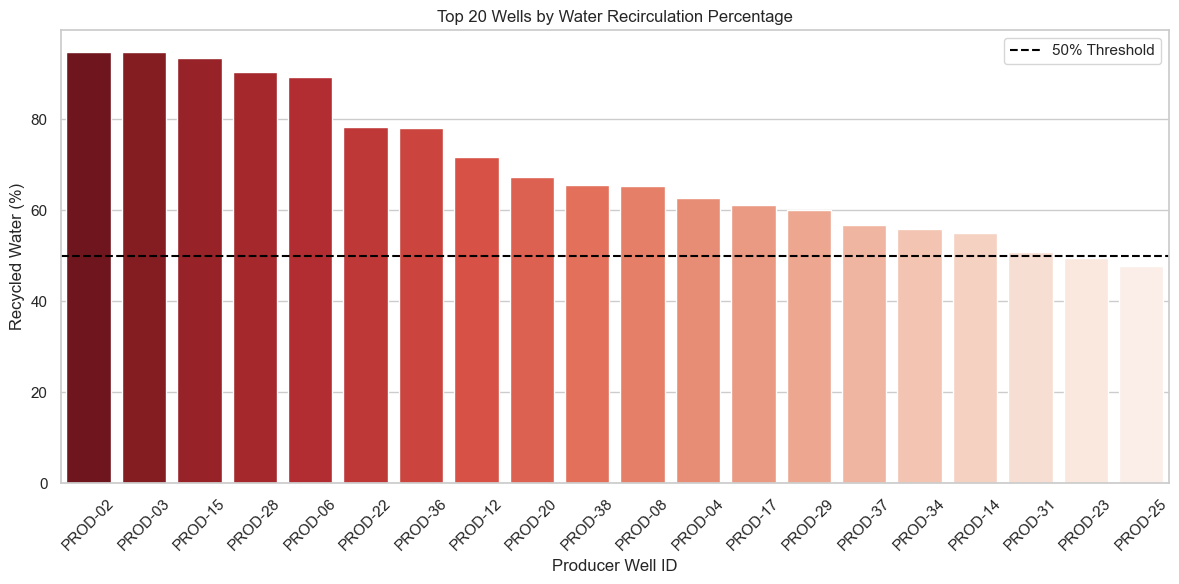

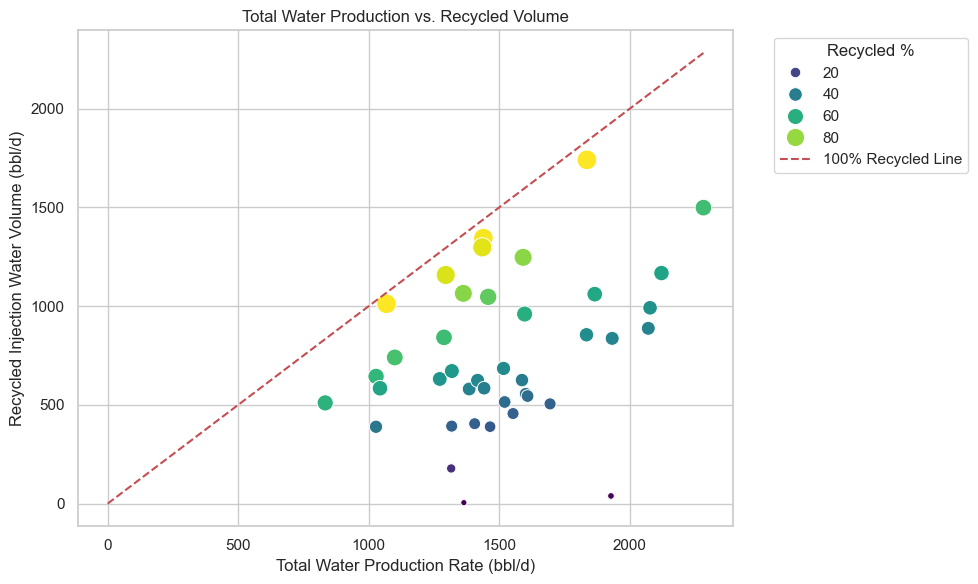

In [5]:
# Plot 1: Recycled Percentage by Well (Top 20 Wells)
top_recyclers = producers_df.sort_values('Recycled_Pct', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_recyclers, x='Well_ID', y='Recycled_Pct', palette='Reds_r')
plt.title('Top 20 Wells by Water Recirculation Percentage')
plt.ylabel('Recycled Water (%)')
plt.xlabel('Producer Well ID')
plt.xticks(rotation=45)
plt.axhline(50, color='black', linestyle='--', label='50% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Scatter plot of Total Water Rate vs Recycled Water Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=producers_df, x='Water_Rate_bpd', y='Recycled_Water_bpd', 
                hue='Recycled_Pct', size='Recycled_Pct', sizes=(20, 200), palette='viridis')
plt.plot([0, producers_df['Water_Rate_bpd'].max()], [0, producers_df['Water_Rate_bpd'].max()], 
         'r--', label='100% Recycled Line')

plt.title('Total Water Production vs. Recycled Volume')
plt.xlabel('Total Water Production Rate (bbl/d)')
plt.ylabel('Recycled Injection Water Volume (bbl/d)')
plt.legend(title='Recycled %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analysis of Water Recirculation Results

## 1. Executive Summary
The analysis of tracer data reveals severe water channeling in a specific subset of producer wells. A significant portion of the injected water is "short-circuiting" directly to producers rather than sweeping the reservoir matrix for oil. This inefficiency is driving up water handling costs without contributing to oil recovery in those specific zones.

## 2. Key Observations

### A. Recirculation Percentage (Bar Chart)
* **Critical "Short-Circuiting":** The top 5 wells (**PROD-02, PROD-03, PROD-15, PROD-28, and PROD-06**) are exhibiting recirculation rates exceeding **80-90%**. This suggests that nearly all the fluid produced by these wells is effectively recycled injection water.
* **Sector-Wide Issue:** Approximately 19 of the top 20 wells are above the **50% recirculation threshold**. This indicates a systemic issue in this sector of the field, rather than an isolated single-well anomaly.

### B. Recycled Volume vs. Total Production (Scatter Plot)
* **Inefficient High-Rate Producers:** The scatter plot highlights a cluster of wells (upper-right quadrant) that are positioned close to the "100% Recycled Line." These wells are not only recycling a high *percentage* of water but are also producing at high *volumes* (>1500 bbl/d).
* **Operational Waste:** These high-rate/high-recycle wells represent the highest operational waste, as energy is expended to inject water that is immediately lifted back to the surface.
* **Low-Risk Candidates:** Wells with moderate water production but very low tracer recycling (bottom center) are likely producing formation water or have aquifer support, indicating they are not currently suffering from injector breakthrough.

## 3. Diagnostic Conclusion
The correlation between the high recirculation percentages and high production rates suggests **strong inter-well connectivity** (e.g., fractures or high-permeability streaks). The injected water is flowing through preferential pathways rather than sweeping the reservoir rock.

## 4. Recommended Next Steps
1.  **Immediate Action:** Prioritize choking back or shutting in **PROD-02** and **PROD-03**. Given their >90% recycling rate, reducing their flow will significantly cut water handling costs with minimal impact on oil production.
2.  **Conformance Control:** Investigate injectors supporting these problem wells for potential water shut-off treatments (e.g., polymer gels) to block high-permeability channels.
3.  **Model Calibration:** Use this tracer data to calibrate a streamline simulation model to map the exact injector-producer pairs responsible for the channeling.